In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers

# ============================================================
# 1) PARÁMETROS FÍSICOS Y DOMINIO
# ============================================================

g = 9.81  # gravedad m/s^2
Sx = 0.10  # pendiente del cauce (10%)
k_f = 0.2  # fricción efectiva [1/s]

# Dominio espacial (ejemplo 10 km x 2 km)
x_min, x_max = 0.0, 10_000.0   # m
y_min, y_max = -1_000.0, 1_000.0  # m

# Tiempo total (20 min)
t_min, t_max = 0.0, 1_200.0  # s

# ============================================================
# 2) TOPOGRAFÍA SENCILLA (PLANO INCLINADO)
# ============================================================

def zb(x, y):
    """
    Topografía del lecho: plano inclinado en x.
    x, y tensores (N,1)
    """
    z0 = 3_000.0  # altura en el inicio del cauce
    return z0 - Sx * x

# ============================================================
# 3) CONDICIÓN INICIAL (PULSO DE LAHAR CERCA DEL VOLCÁN)
# ============================================================

def ic_h(x, y):
    """
    Espesor inicial del lahar: bulto gaussiano en la parte alta.
    """
    x0 = 1_000.0  # centro del pulso en x
    y0 = 0.0      # centro en y
    sigma_x = 800.0
    sigma_y = 400.0
    h0_max = 10.0  # m

    return h0_max * tf.exp(-((x - x0)**2 / (2*sigma_x**2) +
                             (y - y0)**2 / (2*sigma_y**2)))

def ic_u(x, y):
    """
    Velocidad inicial en x: puede partir en reposo.
    """
    return tf.zeros_like(x)

def ic_v(x, y):
    """
    Velocidad inicial en y: puede partir en reposo.
    """
    return tf.zeros_like(y)

# ============================================================
# 4) MUESTRA DE PUNTOS DE ENTRENAMIENTO
# ============================================================

N_ic = 2_000     # puntos de condición inicial (t=0)
N_pde = 10_000   # puntos de colación PDE en todo el dominio

# Condición inicial: t = 0
x_ic = tf.random.uniform((N_ic, 1), x_min, x_max, dtype=tf.float32)
y_ic = tf.random.uniform((N_ic, 1), y_min, y_max, dtype=tf.float32)
t_ic = tf.zeros_like(x_ic, dtype=tf.float32)

h_ic_true = ic_h(x_ic, y_ic)
u_ic_true = ic_u(x_ic, y_ic)
v_ic_true = ic_v(x_ic, y_ic)

# Puntos PDE: (x, y, t) en todo el dominio
x_pde = tf.random.uniform((N_pde, 1), x_min, x_max, dtype=tf.float32)
y_pde = tf.random.uniform((N_pde, 1), y_min, y_max, dtype=tf.float32)
t_pde = tf.random.uniform((N_pde, 1), t_min, t_max, dtype=tf.float32)

# ============================================================
# 5) MODELO PINN: (x,y,t) -> (h,u,v)
# ============================================================

inputs = tf.keras.Input(shape=(3,))

x = layers.Dense(64, activation='tanh')(inputs)
x = layers.Dense(64, activation='tanh')(x)
x = layers.Dense(64, activation='tanh')(x)
x = layers.Dense(64, activation='tanh')(x)
outputs = layers.Dense(3, activation='linear')(x)

# outputs[...,0] = h ; outputs[...,1] = u ; outputs[...,2] = v
model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = optimizers.Adam(learning_rate=1e-3)

# ============================================================
# 6) FUNCIONES AUXILIARES
# ============================================================

@tf.function
def pinn_predict(x, y, t):
    """
    Devuelve h, u, v con forma (N, 1) cada uno.
    """
    inp = tf.concat([x, y, t], axis=1)  # (N,3)
    out = model(inp)
    h = out[:, 0:1]
    u = out[:, 1:2]
    v = out[:, 2:3]
    return h, u, v

@tf.function
def compute_pde_residuals(x, y, t):
    """
    Calcula los residuos de las ecuaciones:
    1) Masa: h_t + (h u)_x + (h v)_y = 0
    2) Mom x: u_t + u u_x + v u_y + g(h+zb)_x + k_f u = 0
    3) Mom y: v_t + u v_x + v v_y + g(h+zb)_y + k_f v = 0
    """

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, y, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, y, t])

            h, u, v = pinn_predict(x, y, t)

            hu = h * u
            hv = h * v

        # Derivadas de primer orden
        h_t = tape1.gradient(h, t)
        h_x = tape1.gradient(h, x)
        h_y = tape1.gradient(h, y)

        u_t = tape1.gradient(u, t)
        u_x = tape1.gradient(u, x)
        u_y = tape1.gradient(u, y)

        v_t = tape1.gradient(v, t)
        v_x = tape1.gradient(v, x)
        v_y = tape1.gradient(v, y)

        hu_x = tape1.gradient(hu, x)
        hv_y = tape1.gradient(hv, y)

    # Topografía y su gradiente
    zb_val = zb(x, y)
    zb_x = tf.constant(-Sx, dtype=tf.float32)  # derivada constante
    zb_x = tf.ones_like(x) * zb_x
    zb_y = tf.zeros_like(y)  # sin variación en y

    # Residuos de las ecuaciones
    # 1) Masa
    f_mass = h_t + hu_x + hv_y

    # 2) Momento en x
    free_surf_x = h_x + zb_x
    f_mom_x = u_t + u * u_x + v * u_y + g * free_surf_x + k_f * u

    # 3) Momento en y
    free_surf_y = h_y + zb_y
    f_mom_y = v_t + u * v_x + v * v_y + g * free_surf_y + k_f * v

    del tape1
    del tape2

    return f_mass, f_mom_x, f_mom_y

# ============================================================
# 7) FUNCIÓN DE PÉRDIDA TOTAL
# ============================================================

mse = tf.keras.losses.MeanSquaredError()

lambda_ic = 10.0   # peso condición inicial
lambda_pde = 1.0   # peso ecuaciones físicas

@tf.function
def train_step():
    with tf.GradientTape() as tape:

        # --- Condición inicial ---
        h_ic_pred, u_ic_pred, v_ic_pred = pinn_predict(x_ic, y_ic, t_ic)

        loss_h_ic = mse(h_ic_true, h_ic_pred)
        loss_u_ic = mse(u_ic_true, u_ic_pred)
        loss_v_ic = mse(v_ic_true, v_ic_pred)

        ic_loss = loss_h_ic + loss_u_ic + loss_v_ic

        # --- Pérdida física (PDE) ---
        f_mass, f_mom_x, f_mom_y = compute_pde_residuals(x_pde, y_pde, t_pde)

        loss_mass = tf.reduce_mean(tf.square(f_mass))
        loss_mom_x = tf.reduce_mean(tf.square(f_mom_x))
        loss_mom_y = tf.reduce_mean(tf.square(f_mom_y))

        pde_loss = loss_mass + loss_mom_x + loss_mom_y

        # --- Pérdida total ---
        loss = lambda_ic * ic_loss + lambda_pde * pde_loss

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss, ic_loss, pde_loss, loss_mass, loss_mom_x, loss_mom_y

# ============================================================
# 8) ENTRENAMIENTO
# ============================================================

epochs = 1_000  # puedes ajustarlo

for epoch in range(epochs):
    loss, ic_loss, pde_loss, loss_mass, loss_mom_x, loss_mom_y = train_step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Total: {loss.numpy():.4e}, "
              f"IC: {ic_loss.numpy():.4e}, "
              f"PDE: {pde_loss.numpy():.4e}, "
              f"Mass: {loss_mass.numpy():.4e}, "
              f"MomX: {loss_mom_x.numpy():.4e}, "
              f"MomY: {loss_mom_y.numpy():.4e}")

print("Entrenamiento PINN para lahares completado.")


Epoch 100/1000 - Total: 3.4712e+01, IC: 3.4127e+00, PDE: 5.8516e-01, Mass: 1.4604e-04, MomX: 5.7574e-01, MomY: 9.2696e-03
Epoch 200/1000 - Total: 3.8717e+01, IC: 3.8400e+00, PDE: 3.1681e-01, Mass: 1.1616e-04, MomX: 3.0976e-01, MomY: 6.9270e-03
Epoch 300/1000 - Total: 3.4093e+01, IC: 3.3849e+00, PDE: 2.4410e-01, Mass: 1.4204e-04, MomX: 2.3887e-01, MomY: 5.0905e-03
Epoch 400/1000 - Total: 3.3647e+01, IC: 3.3565e+00, PDE: 8.1728e-02, Mass: 2.7201e-04, MomX: 7.6643e-02, MomY: 4.8131e-03
Epoch 500/1000 - Total: 3.4620e+01, IC: 3.3867e+00, PDE: 7.5265e-01, Mass: 4.5815e-04, MomX: 7.4382e-01, MomY: 8.3649e-03
Epoch 600/1000 - Total: 3.3692e+01, IC: 3.3449e+00, PDE: 2.4223e-01, Mass: 7.7425e-04, MomX: 2.3522e-01, MomY: 6.2346e-03
Epoch 700/1000 - Total: 3.3316e+01, IC: 3.3193e+00, PDE: 1.2322e-01, Mass: 1.3176e-03, MomX: 1.1581e-01, MomY: 6.0929e-03
Epoch 800/1000 - Total: 3.3774e+01, IC: 3.3620e+00, PDE: 1.5393e-01, Mass: 2.9570e-04, MomX: 1.4736e-01, MomY: 6.2655e-03
Epoch 900/1000 - Total: 

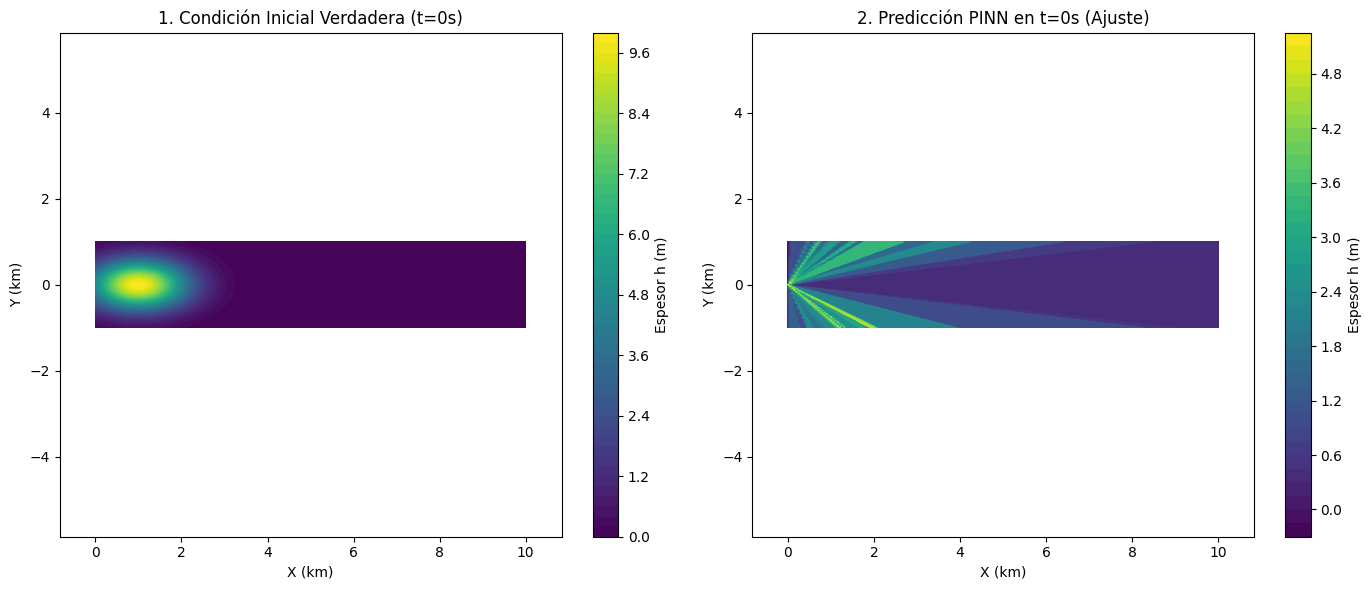

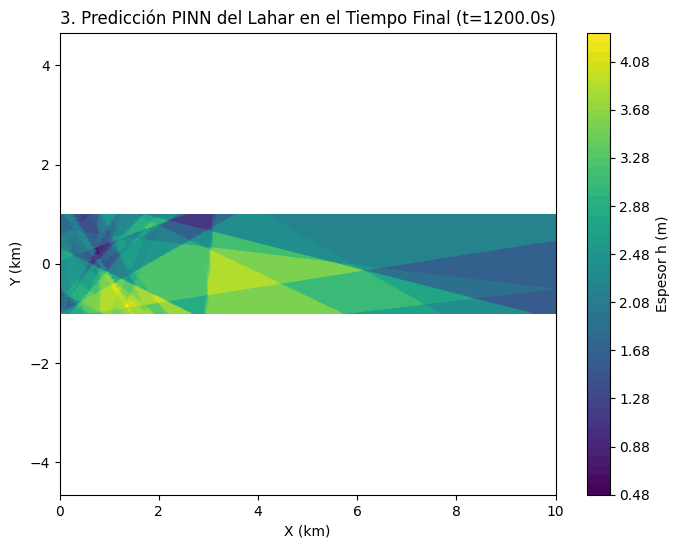

In [2]:
import matplotlib.pyplot as plt
# ============================================================
# 9) VISUALIZACIÓN DE RESULTADOS
# ============================================================

# 9.1) Generar la malla espacial para la visualización
# Usaremos una rejilla de 200x200 puntos
nx, ny = 200, 200
x_space = np.linspace(x_min, x_max, nx)
y_space = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x_space, y_space)

# 9.2) Predicciones para t = 0 (Condición Inicial)
t_ic_plot = t_min  # t=0
T_IC = np.ones_like(X) * t_ic_plot

# Aplanar la malla para alimentar al modelo (X, Y, T_IC) -> (N, 3)
x_flat_ic = X.flatten().reshape(-1, 1)
y_flat_ic = Y.flatten().reshape(-1, 1)
t_flat_ic = T_IC.flatten().reshape(-1, 1)

# Función de predicción del PINN para la malla
h_pred_ic, _, _ = pinn_predict(tf.constant(x_flat_ic, dtype=tf.float32),
                                tf.constant(y_flat_ic, dtype=tf.float32),
                                tf.constant(t_flat_ic, dtype=tf.float32))

# Redimensionar a la malla original (200, 200)
h_ic_pred_grid = h_pred_ic.numpy().reshape(X.shape)

# 9.3) Predicciones para t = t_max (Resultado final)
t_final_plot = t_max # t=1200s
T_FINAL = np.ones_like(X) * t_final_plot

# Aplanar la malla para alimentar al modelo (X, Y, T_FINAL) -> (N, 3)
x_flat_final = X.flatten().reshape(-1, 1)
y_flat_final = Y.flatten().reshape(-1, 1)
t_flat_final = T_FINAL.flatten().reshape(-1, 1)

# Función de predicción del PINN para la malla
h_pred_final, _, _ = pinn_predict(tf.constant(x_flat_final, dtype=tf.float32),
                                tf.constant(y_flat_final, dtype=tf.float32),
                                tf.constant(t_flat_final, dtype=tf.float32))

# Redimensionar a la malla original (200, 200)
h_final_pred_grid = h_pred_final.numpy().reshape(X.shape)

# 9.4) Cálculo de la Condición Inicial "Verdadera" para la malla
# Esto sirve como el "target" de comparación en t=0
h_ic_true_grid = ic_h(tf.constant(x_flat_ic, dtype=tf.float32), 
                      tf.constant(y_flat_ic, dtype=tf.float32)).numpy().reshape(X.shape)


# -------------------------------------------------------------
# GRÁFICOS SOLICITADOS
# -------------------------------------------------------------

# Gráfico 1: Comparación (IC Verdadero vs. PINN Predicción en t=0)
plt.figure(figsize=(14, 6))

# Subplot 1: Condición Inicial (Verdadera)
plt.subplot(1, 2, 1)
cf1 = plt.contourf(X / 1000, Y / 1000, h_ic_true_grid, levels=50, cmap='viridis')
plt.colorbar(cf1, label='Espesor h (m)')
plt.title('1. Condición Inicial Verdadera (t=0s)')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.axis('equal')

# Subplot 2: Predicción PINN en t=0s
plt.subplot(1, 2, 2)
cf2 = plt.contourf(X / 1000, Y / 1000, h_ic_pred_grid, levels=50, cmap='viridis')
plt.colorbar(cf2, label='Espesor h (m)')
plt.title('2. Predicción PINN en t=0s (Ajuste)')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.axis('equal')

plt.tight_layout()
plt.show()

# Gráfico 2: Predicción PINN en el tiempo final (Resultado del Flujo)
plt.figure(figsize=(8, 6))
cf3 = plt.contourf(X / 1000, Y / 1000, h_final_pred_grid, levels=50, cmap='viridis')
plt.colorbar(cf3, label='Espesor h (m)')
plt.title(f'3. Predicción PINN del Lahar en el Tiempo Final (t={t_max}s)')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.axis('equal')
plt.show()

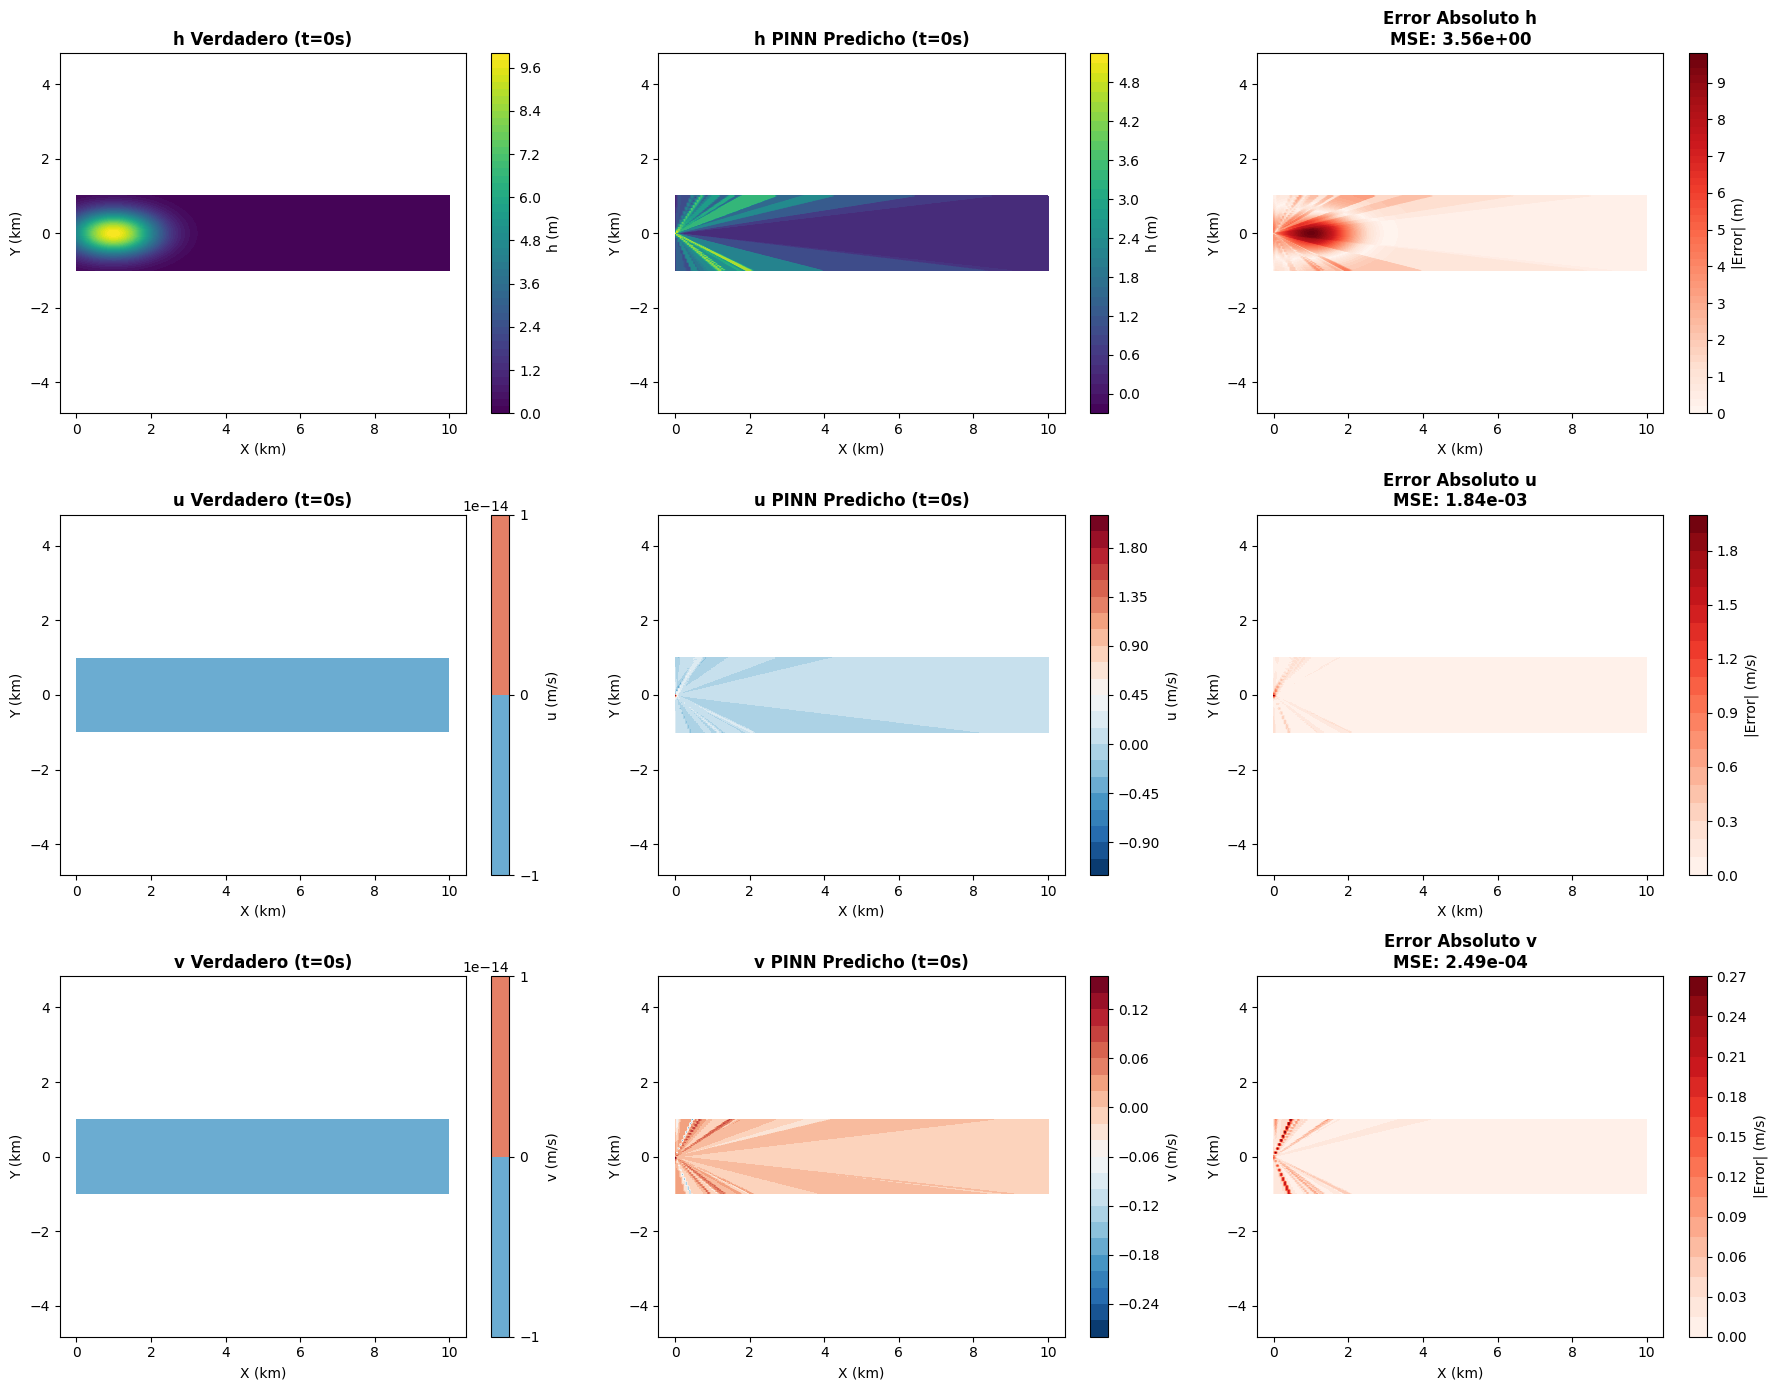


MÉTRICAS DE ERROR EN t=0
Espesor h:
  MSE:  3.564566e+00
  MAE:  1.074961e+00
  Max:  9.664552e+00

Velocidad u:
  MSE:  1.841524e-03
  MAE:  1.334159e-02
  Max:  1.959329e+00

Velocidad v:
  MSE:  2.486395e-04
  MAE:  6.157057e-03
  Max:  2.605688e-01


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# VISUALIZACIÓN COMPARATIVA EN t=0
# ============================================================

# Generar malla espacial
nx, ny = 200, 200
x_space = np.linspace(x_min, x_max, nx)
y_space = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x_space, y_space)

# Preparar datos para t=0
t_ic_plot = t_min
x_flat = X.flatten().reshape(-1, 1)
y_flat = Y.flatten().reshape(-1, 1)
t_flat = np.ones_like(x_flat) * t_ic_plot

# Predicción PINN en t=0
h_pred_ic, u_pred_ic, v_pred_ic = pinn_predict(
    tf.constant(x_flat, dtype=tf.float32),
    tf.constant(y_flat, dtype=tf.float32),
    tf.constant(t_flat, dtype=tf.float32)
)

# Valores verdaderos (condición inicial)
h_true_ic = ic_h(tf.constant(x_flat, dtype=tf.float32), 
                 tf.constant(y_flat, dtype=tf.float32)).numpy()
u_true_ic = ic_u(tf.constant(x_flat, dtype=tf.float32), 
                 tf.constant(y_flat, dtype=tf.float32)).numpy()
v_true_ic = ic_v(tf.constant(x_flat, dtype=tf.float32), 
                 tf.constant(y_flat, dtype=tf.float32)).numpy()

# Reshape a malla
h_pred_grid = h_pred_ic.numpy().reshape(X.shape)
h_true_grid = h_true_ic.reshape(X.shape)
u_pred_grid = u_pred_ic.numpy().reshape(X.shape)
u_true_grid = u_true_ic.reshape(X.shape)
v_pred_grid = v_pred_ic.numpy().reshape(X.shape)
v_true_grid = v_true_ic.reshape(X.shape)

# Calcular error absoluto
h_error = np.abs(h_true_grid - h_pred_grid)
u_error = np.abs(u_true_grid - u_pred_grid)
v_error = np.abs(v_true_grid - v_pred_grid)

# -------------------------------------------------------------
# GRÁFICO COMPLETO: 3x3 (h, u, v) x (Verdadero, Predicho, Error)
# -------------------------------------------------------------

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

# Niveles de contorno
levels_h = 50
levels_uv = 20

# --- FILA 1: ESPESOR h ---
# Verdadero
cf1 = axes[0, 0].contourf(X / 1000, Y / 1000, h_true_grid, levels=levels_h, cmap='viridis')
axes[0, 0].set_title('h Verdadero (t=0s)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('X (km)')
axes[0, 0].set_ylabel('Y (km)')
axes[0, 0].axis('equal')
plt.colorbar(cf1, ax=axes[0, 0], label='h (m)')

# Predicho
cf2 = axes[0, 1].contourf(X / 1000, Y / 1000, h_pred_grid, levels=levels_h, cmap='viridis')
axes[0, 1].set_title('h PINN Predicho (t=0s)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('X (km)')
axes[0, 1].set_ylabel('Y (km)')
axes[0, 1].axis('equal')
plt.colorbar(cf2, ax=axes[0, 1], label='h (m)')

# Error
cf3 = axes[0, 2].contourf(X / 1000, Y / 1000, h_error, levels=levels_h, cmap='Reds')
axes[0, 2].set_title(f'Error Absoluto h\nMSE: {np.mean(h_error**2):.2e}', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('X (km)')
axes[0, 2].set_ylabel('Y (km)')
axes[0, 2].axis('equal')
plt.colorbar(cf3, ax=axes[0, 2], label='|Error| (m)')

# --- FILA 2: VELOCIDAD u ---
# Verdadero
cf4 = axes[1, 0].contourf(X / 1000, Y / 1000, u_true_grid, levels=levels_uv, cmap='RdBu_r')
axes[1, 0].set_title('u Verdadero (t=0s)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('X (km)')
axes[1, 0].set_ylabel('Y (km)')
axes[1, 0].axis('equal')
plt.colorbar(cf4, ax=axes[1, 0], label='u (m/s)')

# Predicho
cf5 = axes[1, 1].contourf(X / 1000, Y / 1000, u_pred_grid, levels=levels_uv, cmap='RdBu_r')
axes[1, 1].set_title('u PINN Predicho (t=0s)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('X (km)')
axes[1, 1].set_ylabel('Y (km)')
axes[1, 1].axis('equal')
plt.colorbar(cf5, ax=axes[1, 1], label='u (m/s)')

# Error
cf6 = axes[1, 2].contourf(X / 1000, Y / 1000, u_error, levels=levels_uv, cmap='Reds')
axes[1, 2].set_title(f'Error Absoluto u\nMSE: {np.mean(u_error**2):.2e}', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('X (km)')
axes[1, 2].set_ylabel('Y (km)')
axes[1, 2].axis('equal')
plt.colorbar(cf6, ax=axes[1, 2], label='|Error| (m/s)')

# --- FILA 3: VELOCIDAD v ---
# Verdadero
cf7 = axes[2, 0].contourf(X / 1000, Y / 1000, v_true_grid, levels=levels_uv, cmap='RdBu_r')
axes[2, 0].set_title('v Verdadero (t=0s)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('X (km)')
axes[2, 0].set_ylabel('Y (km)')
axes[2, 0].axis('equal')
plt.colorbar(cf7, ax=axes[2, 0], label='v (m/s)')

# Predicho
cf8 = axes[2, 1].contourf(X / 1000, Y / 1000, v_pred_grid, levels=levels_uv, cmap='RdBu_r')
axes[2, 1].set_title('v PINN Predicho (t=0s)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('X (km)')
axes[2, 1].set_ylabel('Y (km)')
axes[2, 1].axis('equal')
plt.colorbar(cf8, ax=axes[2, 1], label='v (m/s)')

# Error
cf9 = axes[2, 2].contourf(X / 1000, Y / 1000, v_error, levels=levels_uv, cmap='Reds')
axes[2, 2].set_title(f'Error Absoluto v\nMSE: {np.mean(v_error**2):.2e}', fontsize=12, fontweight='bold')
axes[2, 2].set_xlabel('X (km)')
axes[2, 2].set_ylabel('Y (km)')
axes[2, 2].axis('equal')
plt.colorbar(cf9, ax=axes[2, 2], label='|Error| (m/s)')

plt.tight_layout()
plt.savefig('comparacion_t0_pinn_lahar.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------
# MÉTRICAS DE ERROR
# -------------------------------------------------------------
print("\n" + "="*60)
print("MÉTRICAS DE ERROR EN t=0")
print("="*60)
print(f"Espesor h:")
print(f"  MSE:  {np.mean(h_error**2):.6e}")
print(f"  MAE:  {np.mean(h_error):.6e}")
print(f"  Max:  {np.max(h_error):.6e}")
print(f"\nVelocidad u:")
print(f"  MSE:  {np.mean(u_error**2):.6e}")
print(f"  MAE:  {np.mean(u_error):.6e}")
print(f"  Max:  {np.max(u_error):.6e}")
print(f"\nVelocidad v:")
print(f"  MSE:  {np.mean(v_error**2):.6e}")
print(f"  MAE:  {np.mean(v_error):.6e}")
print(f"  Max:  {np.max(v_error):.6e}")
print("="*60)